In [90]:
import pandas as pd
import chordparser
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

---------------

### Definitions

In [91]:
cp = chordparser.Parser()
CE = chordparser.ChordEditor()
CRC = chordparser.ChordRomanConverter()

In [92]:
sharps_to_flats = {
    'C#': 'Db',
    'D#': 'Eb',
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
}

In [93]:
lower_base = {
    'C': 'B',
    'B': 'Bb',
    'Bb': 'A',
    'A': 'Ab',
    'Ab': 'G',
    'G': 'Gb',
    'Gb': 'F',
    'F': 'E',
    'E': 'Eb',
    'Eb': 'D',
    'D': 'Db',
    'Db': 'C'
}

In [94]:
number_of_songs = {'Country': 0,
                   'Electronic': 0,
                   'Pop': 0,
                   'Rock': 0}

In [95]:
# {'Country': ['major', 'minor', 'minor', ...], 'Pop': ...}
modes = {'Country': [],
        'Electronic': [],
        'Pop': [],
        'Rock': []}

In [96]:
# {'Country': {'IV': 30, 'V': 2, ...}, 'Pop': {...}, ...}
nodelists_sum = {'Country': {},
                 'Electronic': {},
                 'Pop': {},
                 'Rock': {}}

In [97]:
dataframes = {'Country': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Electronic': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Pop': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Rock': pd.DataFrame(columns=['from_roman', 'to_roman'])}

In [98]:
nodelists = {}

----------------------

### Single song processing

In [99]:
def get_roman_dataframe(file):
    # dataframe
    df = pd.read_csv(file, delimiter='\t', skiprows=2, header=None)
    df.columns=['from', 'to']

    # signature
    with open(file, "r") as fin:
        signature = fin.readlines()[:2]
        
    base = re.split(':|\\n', signature[0])[1]
    capo = re.split(':|\\n', signature[1])[1]
    
    if capo == 'None':
        capo = 0
    else:
        capo = int(capo)

    # key and scale
    if('m' in base):
        mode = 'minor'
        base = base.replace('m', '')
    else:
        mode = 'major'
        
    if base in sharps_to_flats.keys() and base != df['from'][0].replace('m', ''):
        base = sharps_to_flats[base]  

    for i in range(capo):
        base = lower_base[base]

    key = cp.create_key(base, mode)

    df['from'] = df['from'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))
    df['to'] = df['to'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))

    # add mode to dict
    genre = file.split('/')[2]
    modes[genre].append(mode)

    # convert to roman
    if base in sharps_to_flats.keys():
        base = sharps_to_flats[base]  
        
    df['from_roman'] = df['from'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    df['to_roman'] = df['to'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    
    df = df.drop(columns=['from','to'])

    return df

In [100]:
def add_to_nodelist(df, genre):    
    all_chords = pd.unique(df.values.ravel('K'))
        
    for chord in all_chords:
        value_count = 0
        
        if chord in df.from_roman.values:
            value_count = df.from_roman.value_counts()[chord]

        # include last chord
        if (df.to_roman.iloc[-1]) == chord:
            value_count += 1

        # add appearances to nodelist
        if chord not in nodelists_sum[genre].keys():
            nodelists_sum[genre][chord] = 0
        nodelists_sum[genre][chord] += value_count

    return

In [101]:
def process_song(file):

    df = get_roman_dataframe(file)
    
    genre = file.split('/')[2]
    
    dataframes[genre] = dataframes[genre].append(df)
    add_to_nodelist(df, genre)

    number_of_songs[genre] += 1

### Genre processing

In [102]:
def create_nodelist(genre):
    df = pd.DataFrame([nodelists_sum[genre]])
    df = df.T.rename(columns={0: 'sum_appearance'})
    
    df['percent'] = df['sum_appearance'] / df['sum_appearance'].sum()
    df['average_appearance'] = df['sum_appearance'] / number_of_songs[genre]

    df = df.reset_index()
    df = df.rename(columns={'index': 'Id'})
    
    return df

In [103]:
def get_percentages(df, nodelist):

    df = df.groupby(df.columns.tolist(),as_index=False).size()
    df['percent'] = df['size'] / df['size'].sum()
    
    df = df.rename(columns={'size': 'sum_appearance', 'from_roman': 'Source', 'to_roman': 'Target'})

    log_ratio = []
    for i, row in df.iterrows():
        source_percent = nodelist.loc[nodelist['Id'] == row.Source, 'percent'].iloc[0]
        target_percent = nodelist.loc[nodelist['Id'] == row.Target, 'percent'].iloc[0]
        log_ratio.append(np.log(row.percent / (source_percent * target_percent)))

    df['log_ratio'] = log_ratio

    return df

In [104]:
def get_probabilities(df):
    
    probs = []
    for i, row in df.iterrows():
        from_chord_df = df[df['Source'] == row.Source]
        probs.append(row['sum_appearance'] / from_chord_df['sum_appearance'].sum())

    df['probability'] = probs
    
    return df

--------------

## Main

### Process every song

In [105]:
directory = '../data/'

for subdir, dirs, files in os.walk(directory):
    for i, filename in enumerate(os.listdir(subdir)):
        f = os.path.join(subdir, filename)
        if os.path.isfile(f):
            df = process_song(f)

### Process genres and save intermittent dataframes

In [106]:
for genre, df in dataframes.items():
    nodelists[genre] = create_nodelist(genre)

    dataframes[genre] = get_percentages(df, nodelists[genre])
    dataframes[genre] = get_probabilities(dataframes[genre])

### Log-Ratio

In [107]:
dataframes['Pop'][dataframes['Pop']['percent']>0.003].sort_values('probability', ascending=False)

,Source,Target,sum_appearance,percent,log_ratio,probability
35,I6,IV,47,0.004969,1.884760,0.723077
385,vii,V,78,0.008247,1.695970,0.639344
448,♭VII,i,30,0.003172,1.865677,0.491803
78,III,VII,217,0.022944,1.739023,0.442857
377,vi7,IV,29,0.003066,1.386640,0.439394
...,...,...,...,...,...,...
125,IV,ii,36,0.003806,0.129558,0.034286
163,V,iii,38,0.004018,0.533844,0.033838
162,V,ii,34,0.003595,0.006682,0.030276
2,I,I6,37,0.003912,1.460069,0.029600


### Co-occurence Matrix

In [108]:
coocc = {}

In [109]:
import networkx

for genre, df in dataframes.items():
    edgeList = df[['Source', 'Target', 'log_ratio']][df['percent']>0.01].values.tolist()
    G = networkx.DiGraph()
    for i in range(len(edgeList)):
        G.add_edge(edgeList[i][0], edgeList[i][1], weight=edgeList[i][2])

    coocc[genre] = networkx.to_pandas_adjacency(G, nodelist=list(df[df['percent']>0.01].Source.unique()))

In [110]:
coocc['Pop']

,I,III,IV,V,VI,VII,i,ii,vi
I,0.274730,0.000000,0.446586,0.571527,0.000000,0.000000,0.000000,0.0,0.690525
III,0.000000,0.000000,0.000000,0.000000,0.000000,1.739023,0.000000,0.0,0.000000
IV,0.777826,0.000000,0.000000,0.840219,0.000000,0.000000,0.000000,0.0,0.569256
V,0.983261,0.000000,0.413700,0.000000,0.000000,0.000000,0.000000,0.0,0.661346
VI,0.000000,1.605140,0.000000,0.000000,0.000000,0.937874,0.839477,0.0,0.000000
VII,0.000000,0.944093,0.000000,0.000000,1.460628,0.000000,1.384479,0.0,0.000000
i,0.000000,1.134604,0.000000,0.000000,0.992553,1.450148,0.000000,0.0,0.000000
ii,0.000000,0.000000,0.000000,1.065289,0.000000,0.000000,0.000000,0.0,0.000000
vi,0.000000,0.000000,1.080082,0.668619,0.000000,0.000000,0.000000,0.0,0.000000


Save cooccurence matrices

In [111]:
for genre in nodelists.keys():
    coocc[genre].to_csv('../results/coocc/coocc_' + genre + '.csv')

Get only values that have at least one co-occurence of a certain threshold, depending on the genre.

In [112]:
mask = ((coocc['Country'] >= 0.5))
coocc_filtered = coocc['Country'][mask.any()].T[mask.any()].T

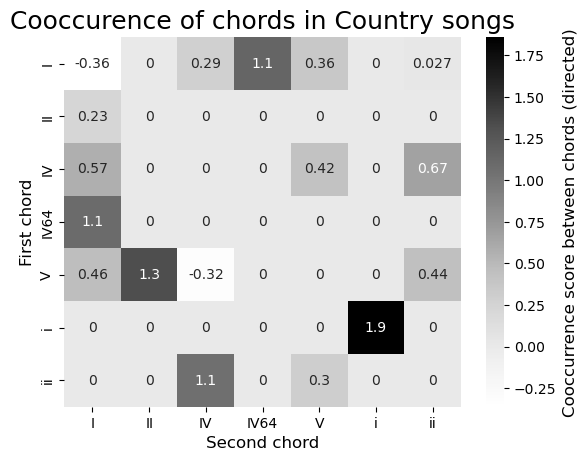

In [113]:
ax = sns.heatmap(coocc_filtered, cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'}, annot=True)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Country songs', fontsize=18)

In [114]:
mask = ((coocc['Electronic'] >=1.5))
coocc_filtered = coocc['Electronic'][mask.any()].T[mask.any()].T

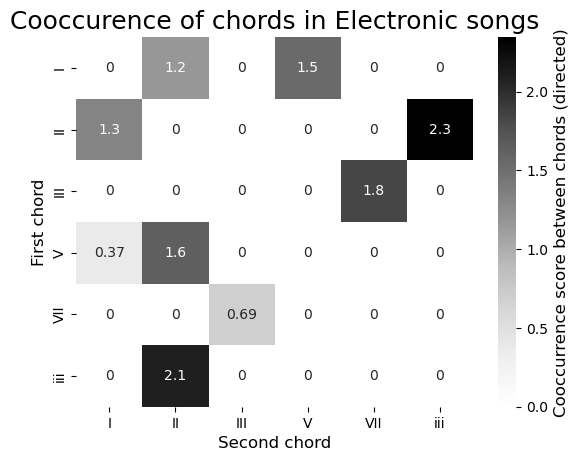

In [115]:
ax = sns.heatmap(coocc_filtered, cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'}, annot=True)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Electronic songs', fontsize=18)

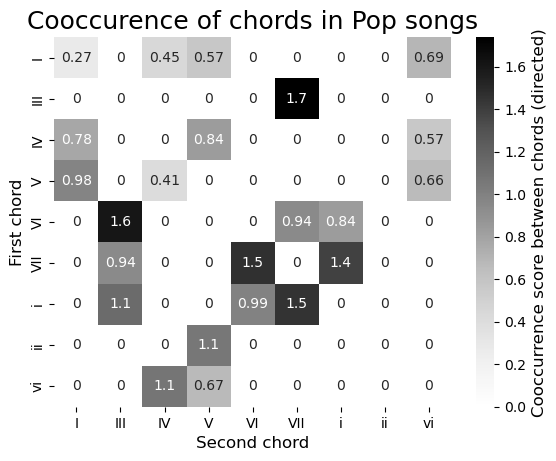

In [116]:
ax = sns.heatmap(coocc['Pop'], cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'}, annot=True)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Pop songs', fontsize=18)

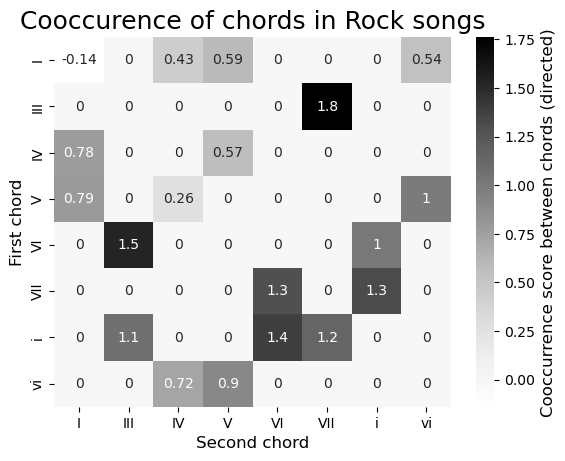

In [117]:
ax = sns.heatmap(coocc['Rock'], cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'}, annot=True)
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Rock songs', fontsize=18)